# Biorez Image Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import

In [2]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

## Load Data

In [3]:
tfrecord_path = '/content/drive/MyDrive/BIOREZv2/waste/dataset/train_data.tfrecord'

if not os.path.exists(tfrecord_path):
    raise FileNotFoundError(f"File tidak ditemukan: {tfrecord_path}")


In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 8
NUM_CLASSES = 2
VALIDATION_SPLIT = 0.2

In [5]:
def _parse_image_function(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.cast(example['label'], tf.int64)
    return image, label

In [6]:
def prepare_dataset(filepath, shuffle_buffer_size=1000):
    dataset = tf.data.TFRecordDataset(filepath)
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [7]:
raw_dataset = prepare_dataset(tfrecord_path)
dataset_size = sum(1 for _ in raw_dataset)
print(f"Total data: {dataset_size}")

if dataset_size == 0:
    raise ValueError("Dataset kosong. Pastikan file TFRecord valid.")

Total data: 25077


In [8]:
val_size = int(dataset_size * VALIDATION_SPLIT)
train_size = dataset_size - val_size

train_ds = raw_dataset.take(train_size)
val_ds = raw_dataset.skip(train_size)

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Model Definition (MobileNetV2)

In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
initial_epochs = 10
history = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

Epoch 1/10
   2508/Unknown 47s 15ms/step - accuracy: 0.9953 - loss: 0.0165

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2508/2508 ━━━━━━━━━━━━━━━━━━━━ 75s 26ms/step - accuracy: 0.9953 - loss: 0.0165 - val_accuracy: 1.0000 - val_loss: 2.8621e-05
Epoch 2/10
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - accuracy: 0.9839 - loss: 0.1023 - val_accuracy: 1.0000 - val_loss: 2.7262e-04
Epoch 3/10
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.9870 - loss: 0.0798 - val_accuracy: 1.0000 - val_loss: 3.3468e-04
Epoch 4/10
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step - accuracy: 0.9867 - loss: 0.0579 - val_accuracy: 1.0000 - val_loss: 1.8564e-04
Epoch 5/10
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 83s 21ms/step - accuracy: 0.9871 - loss: 0.0628 - val_accuracy: 1.0000 - val_loss: 3.2280e-04
Epoch 6/10
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - accuracy: 0.9883 - loss: 0.0390 - val_accuracy: 1.0000 - val_loss: 1.0451e-04
Epoch 7/10
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 144s 45ms/step - accuracy: 0.9869 - loss: 0.0753 - val_accuracy: 1.0000 - val_loss: 2.1747e-04
Epoch 8/10
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - 

In [11]:
# Visualisasikan hasil pelatihan awal
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

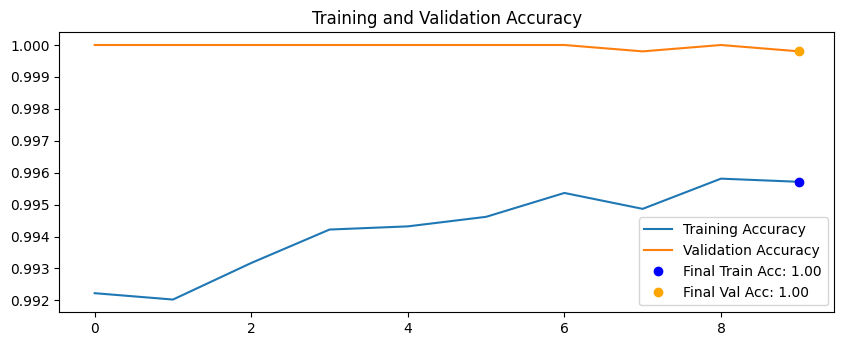

In [12]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1], [acc[-1]], 'o', color='blue', label=f'Final Train Acc: {acc[-1]:.2f}')
plt.plot([initial_epochs-1], [val_acc[-1]], 'o', color='orange', label=f'Final Val Acc: {val_acc[-1]:.2f}')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

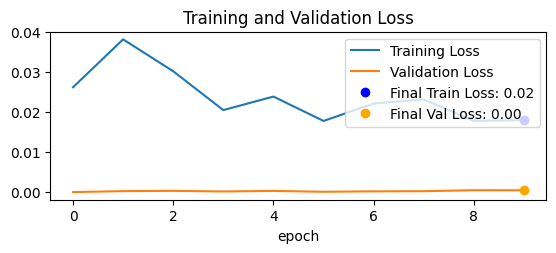

In [13]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1], [loss[-1]], 'o', color='blue', label=f'Final Train Loss: {loss[-1]:.2f}')
plt.plot([initial_epochs-1], [val_loss[-1]], 'o', color='orange', label=f'Final Val Loss: {val_loss[-1]:.2f}')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

In [14]:
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

In [17]:
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 67s 23ms/step - accuracy: 0.8208 - loss: 0.8658 - val_accuracy: 0.9924 - val_loss: 0.0232
Epoch 11/20
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 78s 31ms/step - accuracy: 0.9591 - loss: 0.1519 - val_accuracy: 0.9924 - val_loss: 0.0213
Epoch 12/20
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 57s 21ms/step - accuracy: 0.9716 - loss: 0.1009 - val_accuracy: 0.9944 - val_loss: 0.0167
Epoch 13/20
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.9782 - loss: 0.0848 - val_accuracy: 0.9946 - val_loss: 0.0143
Epoch 14/20
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - accuracy: 0.9783 - loss: 0.0789 - val_accuracy: 0.9950 - val_loss: 0.0150
Epoch 15/20
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.9837 - loss: 0.0517 - val_accuracy: 0.9948 - val_loss: 0.0152
Epoch 16/20
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.9844 - loss: 0.0589 - val_accuracy: 0.9948 - val_loss: 0.0160
Epoch 17/20
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - accuracy: 

### Evaluate & Visualization

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

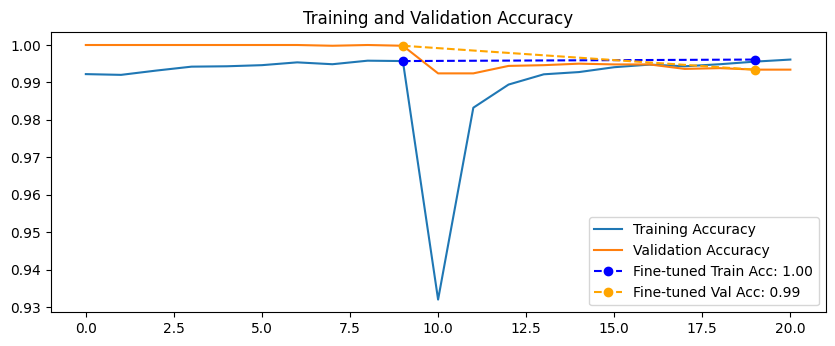

In [19]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1, total_epochs-1], [acc[initial_epochs-1], acc[-1]], 'o--', color='blue', label=f'Fine-tuned Train Acc: {acc[-1]:.2f}')
plt.plot([initial_epochs-1, total_epochs-1], [val_acc[initial_epochs-1], val_acc[-1]], 'o--', color='orange', label=f'Fine-tuned Val Acc: {val_acc[-1]:.2f}')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

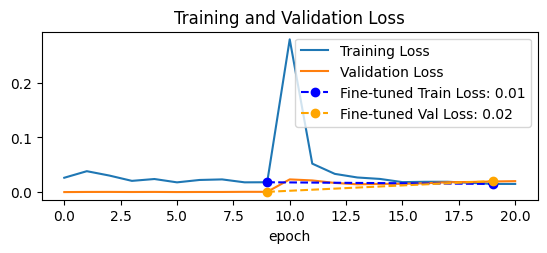

In [20]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1, total_epochs-1], [loss[initial_epochs-1], loss[-1]], 'o--', color='blue', label=f'Fine-tuned Train Loss: {loss[-1]:.2f}')
plt.plot([initial_epochs-1, total_epochs-1], [val_loss[initial_epochs-1], val_loss[-1]], 'o--', color='orange', label=f'Fine-tuned Val Loss: {val_loss[-1]:.2f}')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
true_labels = []
predictions = []

for images, labels in val_ds:
    true_labels.extend(labels.numpy())

    preds = model.predict(images)

    predicted_classes = np.argmax(preds, axis=1)
    predictions.extend(predicted_classes)

true_labels = np.array(true_labels)
predictions = np.array(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━

In [22]:
print("\nConfusion Matrix:")
labels = ['Organik', 'Anorganik']
cm = confusion_matrix(true_labels, predictions)
print(cm)


Confusion Matrix:
[[   0    0]
 [  33 4982]]


In [23]:
print("\nClassification Report:")
target_names = ['Organik', 'Anorganik']
cr = classification_report(true_labels, predictions, target_names=target_names)
print(cr)


Classification Report:
              precision    recall  f1-score   support

     Organik       0.00      0.00      0.00         0
   Anorganik       1.00      0.99      1.00      5015

    accuracy                           0.99      5015
   macro avg       0.50      0.50      0.50      5015
weighted avg       1.00      0.99      1.00      5015



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Save Models

In [24]:
!pip install packaging==24.2

In [25]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [26]:
model.save("biorez.h5")

save_path = "saved_model/"
tf.saved_model.save(model, save_path)


In [27]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model/ tfjs_model/


2025-06-14 09:50:50.090739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749894650.110849   16140 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749894650.116964   16140 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-14 09:50:56.232435: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1749894656.232598   16140 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [28]:
saved_model_dir = "/content/saved_model"

# Konversi langsung dari direktori SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter.experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Simpan model TFLite
output_directory = "tflite"
os.makedirs(output_directory, exist_ok=True)
tflite_model_path = os.path.join(output_directory, "model.tflite")
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# Simpan label
labels = ['Organik', 'Anorganik']
labels_file_path = os.path.join(output_directory, "labels.txt")
with open(labels_file_path, "w") as f:
    for label in labels:
        f.write(label + "\n")
